<img src="../../images/wt4.png" align="right" width="70"/>

  #     Notebook for early bearing fault detection for WT04



## Table of contents
1. Raw signal
2. Resampled signal
3. Filtered signal with optimal bandpass based on SK
4. Demodulasation using EEMD signals
5. Selecting IMF: Correlation coefficient
6. Envelope spectral analyis
7. Frequency study

In [328]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [329]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, os,os.path
ROOT_PATH = os.path.abspath("..").split("data_processing")[0]
module_paths = []
module_paths.append(os.path.abspath(os.path.join(ROOT_PATH+"/data_processing/")))
module_paths.append(os.path.abspath(os.path.join(ROOT_PATH+"/hybrid_analysis_process_functions/")))
module_paths.append(os.path.abspath(os.path.join(ROOT_PATH+"/utils/")))
for module_path in module_paths:
    if module_path not in sys.path:
        print("appended")
        sys.path.append(module_path)
%autoreload
import functions as f
import wt_data, ff_transform, explore_fft_time_data, envelope, build_dataset, load_raw_signals, envelope, envelope_emd,plotting_methods
import resample_signals, filter_signals, plotting_methods,filters

## 1. Raw signal 

In [175]:
vib_signal, times, op_data_intervals, peak_array = load_raw_signals.load_raw('gearbox','wt04')

File exist


5
110886912


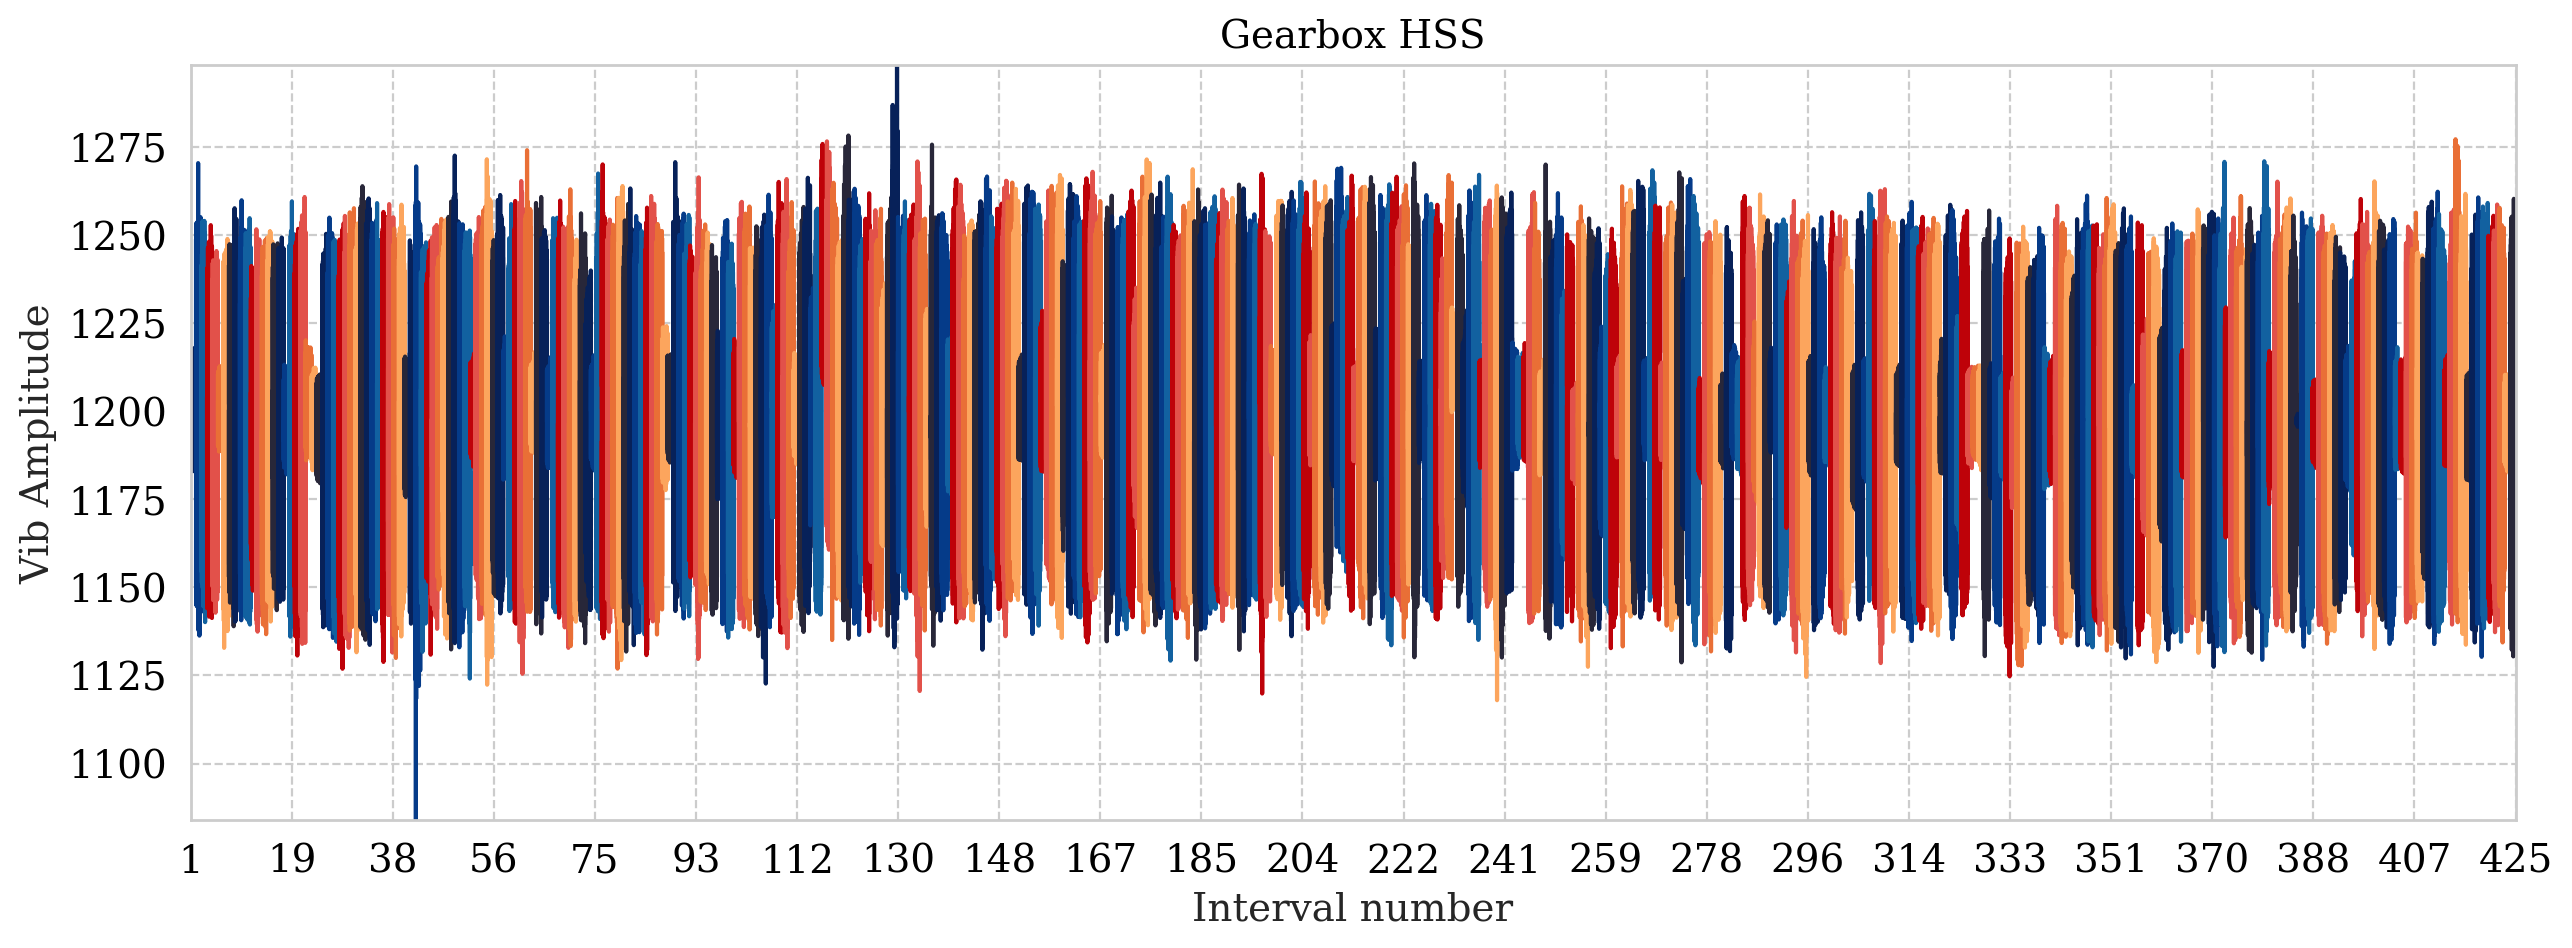

In [176]:
envelope.plot_vib_consecutive(vib_signal)

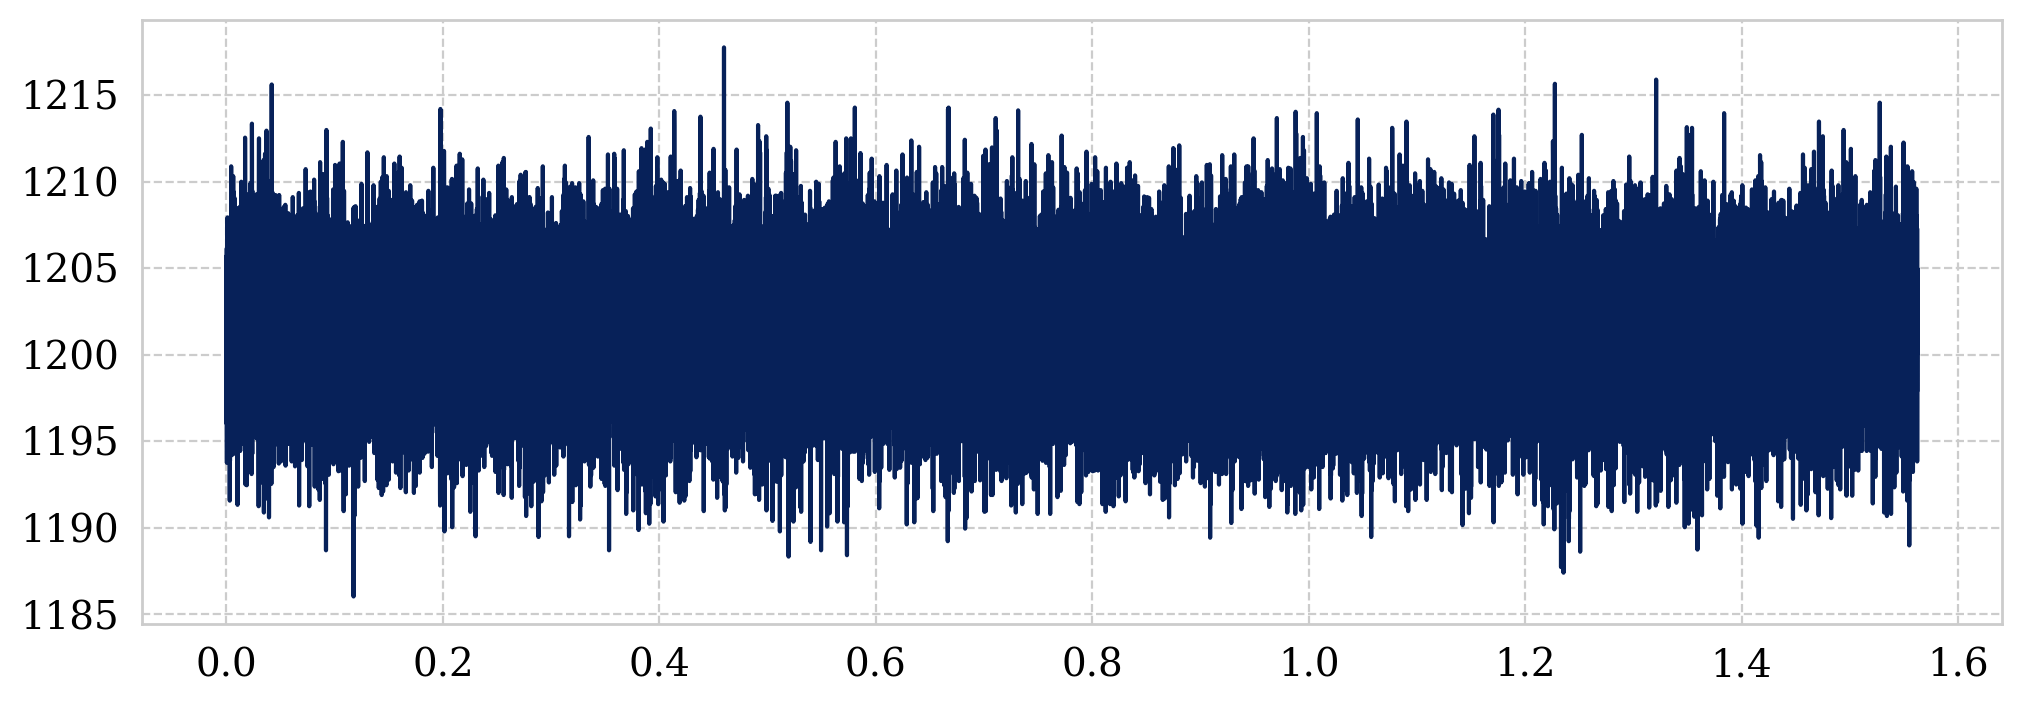

In [177]:
# One interval:
plt.plot(times[0][0:40000],vib_signal[0][0:40000])

## 2. Resampled signal

In [257]:
# The resampled signal is filtered (Lowcut at 200 Hz (highpass))
filtered_resampled_path = '/Volumes/OsvikExtra/signal_data/resampled_filtered_2000Hz/gearbox/wt04/filtered_resampled/'


num_csvs = len([f for f in os.listdir(filtered_resampled_path) 
     if f.endswith('.csv') and os.path.isfile(os.path.join(filtered_resampled_path, f)) and f[0]=='f'])

filtered_resampled_signals = []
resample_freqs = []
columns = []
for i in range(num_csvs):
    acc=pd.read_csv(filtered_resampled_path+'filtered_resampled_'+str(i)+'.csv')
    columns.append('filtered_resampled_' + str(i))
    filtered_resampled_signals.append(acc.values)
    resample_freqs.append(acc.shape[0] / times[i][-1])

['filtered_resampled_0',
 'filtered_resampled_1',
 'filtered_resampled_2',
 'filtered_resampled_3',
 'filtered_resampled_4',
 'filtered_resampled_5',
 'filtered_resampled_6',
 'filtered_resampled_7',
 'filtered_resampled_8',
 'filtered_resampled_9',
 'filtered_resampled_10',
 'filtered_resampled_11',
 'filtered_resampled_12',
 'filtered_resampled_13',
 'filtered_resampled_14',
 'filtered_resampled_15',
 'filtered_resampled_16',
 'filtered_resampled_17',
 'filtered_resampled_18',
 'filtered_resampled_19',
 'filtered_resampled_20',
 'filtered_resampled_21',
 'filtered_resampled_22',
 'filtered_resampled_23',
 'filtered_resampled_24',
 'filtered_resampled_25',
 'filtered_resampled_26',
 'filtered_resampled_27',
 'filtered_resampled_28',
 'filtered_resampled_29',
 'filtered_resampled_30',
 'filtered_resampled_31',
 'filtered_resampled_32',
 'filtered_resampled_33',
 'filtered_resampled_34',
 'filtered_resampled_35',
 'filtered_resampled_36',
 'filtered_resampled_37',
 'filtered_resampled_3

In [265]:
resample_freqs
resample_freqs = pd.DataFrame(resample_freqs,columns)

## 3. Filtered signal with optimal bandpass based on SK

In [172]:
# Read kurtogram data
fc_and_bw_path = '/Volumes/OsvikExtra/signal_data/resampled_filtered_2000Hz/gearbox/wt04/center_frequencies_&_bandwidth/fc_and_bw_data.csv';
frequencies_path = '/Volumes/OsvikExtra/signal_data/resampled_filtered_2000Hz/gearbox/wt04/center_frequencies_&_bandwidth/frequencies.csv';
file_names_path = '/Volumes/OsvikExtra/signal_data/resampled_filtered_2000Hz/gearbox/wt04/center_frequencies_&_bandwidth/file_name.txt';

fc_and_bw = pd.read_csv(fc_and_bw_path)
frequencies = pd.read_csv(frequencies_path)
file_names = pd.read_csv(file_names_path, header=None)

frequencies_numpy = np.asarray(frequencies).T
frequencies = pd.DataFrame(frequencies_numpy, columns= frequencies_numpy[0])
frequencies = frequencies.drop(frequencies.index[0]).reset_index(drop=True)

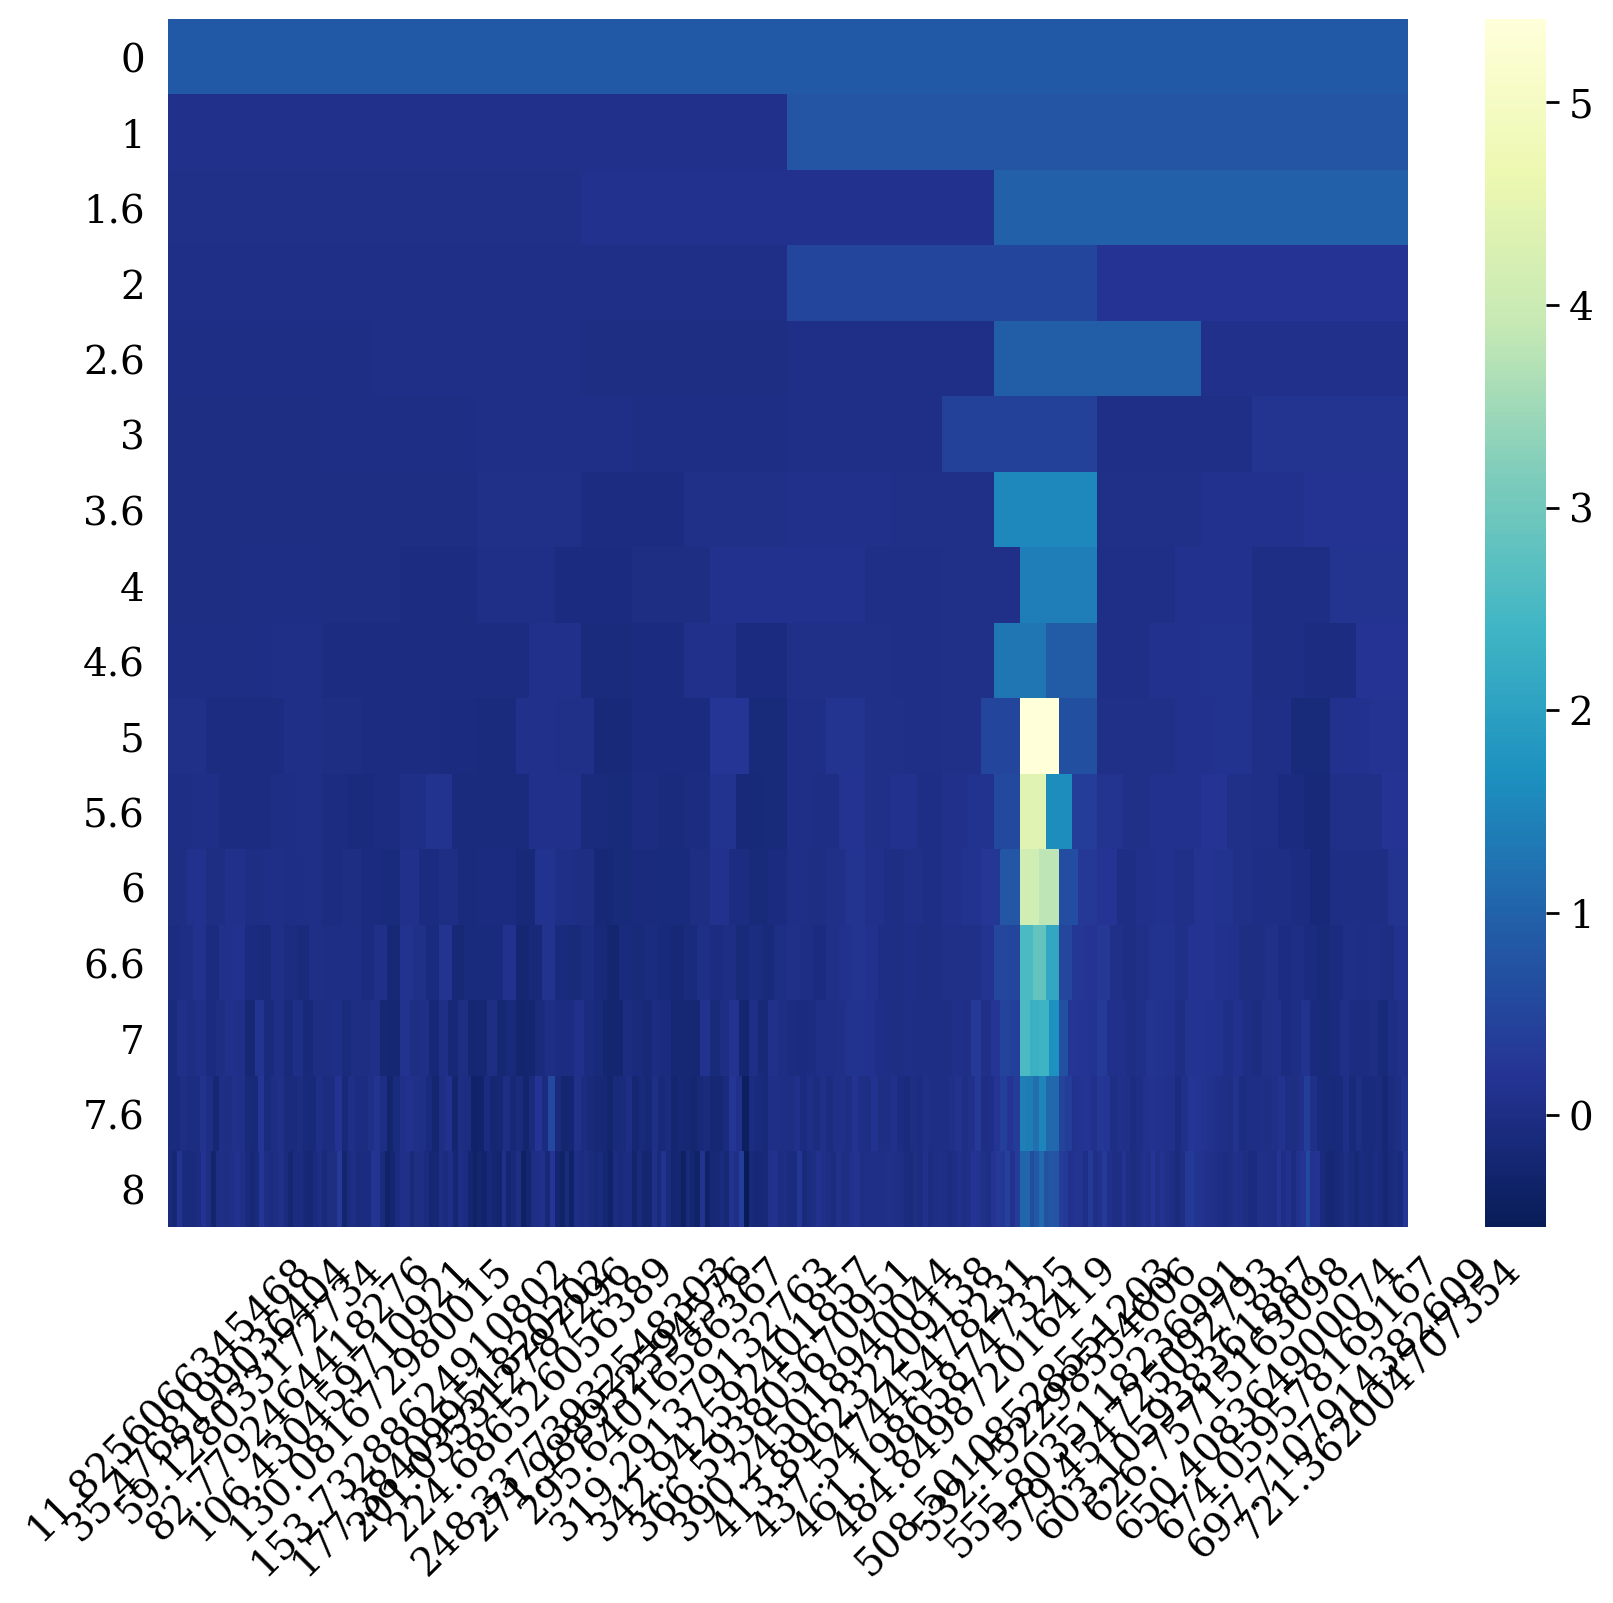

['filtered_resampled_1.csv']

In [174]:
kurtogram = pd.read_csv(kurt_file, header=None)
plotting_methods.plot_kurtogram(kurtogram, frequencies['filtered_resampled_1.csv'])
['filtered_resampled_1.csv']

In [138]:
# Finding the optimal bandwidth by taking the mean from the SK
fc_and_bw_data = '/Volumes/OsvikExtra/signal_data/resampled_filtered_2000Hz/gearbox/wt04/center_frequencies_&_bandwidth/fc_and_bw_data.csv'
fc_and_bw_data = pd.read_csv(fc_and_bw_data)
# Make the file column to an int
fc_and_bw_data['File']=fc_and_bw_data['File'].apply(lambda x: int((str(x).split('_'))[2].split('.csv')[0]))
# Sort the df based on this
fc_and_bw_data=fc_and_bw_data.sort_values('File',ascending=True)
fc_and_bw_data = fc_and_bw_data.reset_index(drop=True)

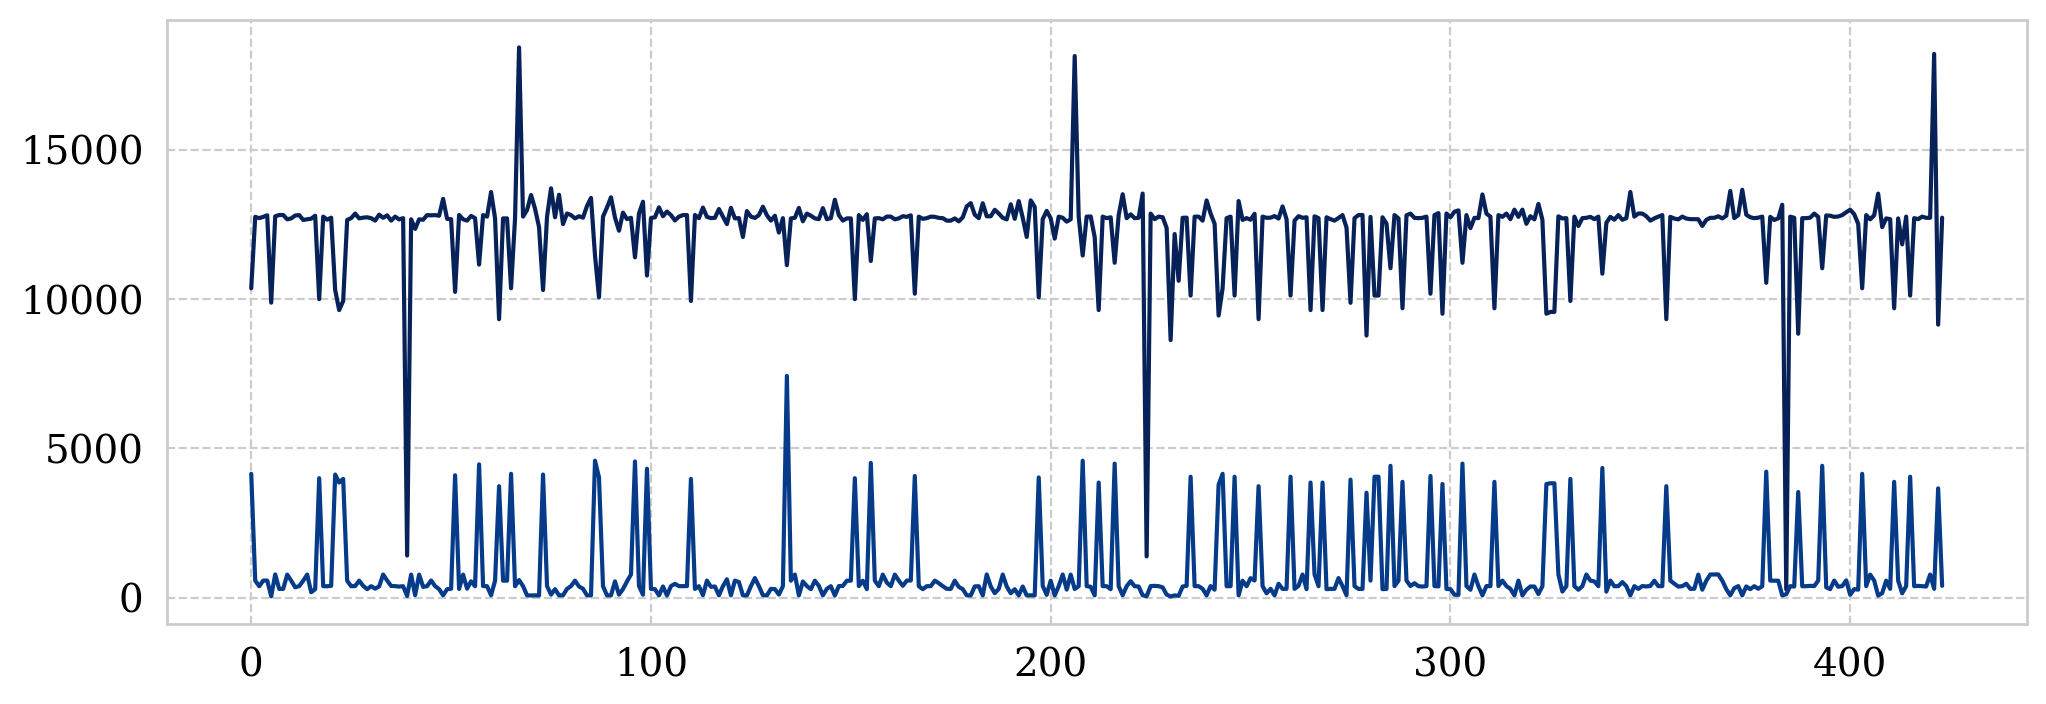

In [139]:
fc_and_bw_data['Frequencies'].plot()
fc_and_bw_data['Bandwidths'].plot()

Before filter shape: (424, 9)
After filtering: (322, 9)


,Unnamed: 0,AvgPower,ActPower,WindSpeed,NacelleDirection,AvgSpeed,File,Frequencies,Bandwidths
1,1,2697.461426,2332.100098,9.1,256.100006,1456.464986,1,12771.655165,567.629118
2,2,2606.151855,2843.500000,10.0,240.199997,1468.503663,2,12728.167451,379.945297
3,3,2541.849854,2694.100098,10.5,71.099998,1458.875183,3,12771.655165,567.629118
4,4,2853.304199,3293.399902,12.7,269.399994,1460.635409,4,12823.153775,569.917946
6,6,2752.077881,3040.300049,9.7,143.899994,1490.140485,6,12789.965782,775.149441
...,...,...,...,...,...,...,...,...,...
418,418,2579.166504,2568.500000,10.3,266.500000,1469.268894,418,12779.284589,381.471182
419,419,2565.862793,1585.199951,7.7,358.799988,1420.395518,419,12739.611586,369.264104
420,420,2891.829346,2819.300049,10.4,318.600006,1487.214505,420,12739.611586,772.097672
421,421,2581.525879,3160.600098,10.2,317.000000,1489.520070,421,18239.090878,291.825454


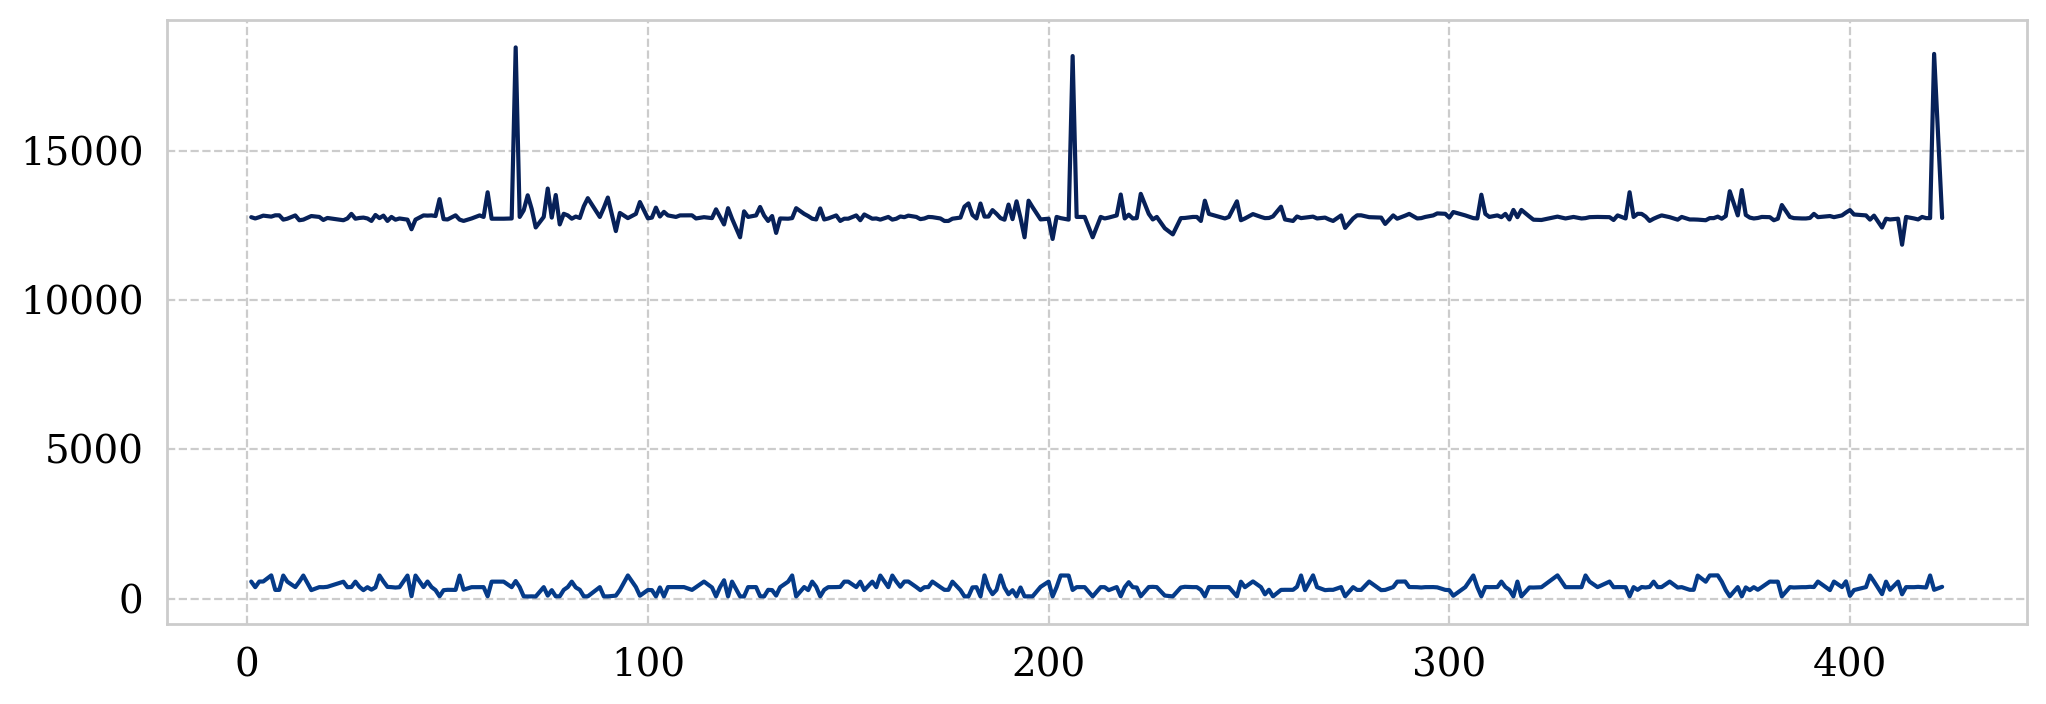

In [226]:
op_data_intervals
concated = pd.concat([op_data_intervals, fc_and_bw_data],axis=1)
print(f"Before filter shape: {concated.shape}")
filter_concated = concated.loc[(concated['AvgSpeed'] >= 1400)]
print(f"After filtering: {filter_concated.shape}")
mean_freq = filter_concated['Frequencies'].mean()
mean_bw = filter_concated['Bandwidths'].mean()
filter_concated['Frequencies'].plot()
filter_concated['Bandwidths'].plot()
filter_concated

In [224]:
filter_concated = concated.loc[(concated['Frequencies'] > 18000)]
filter_concated

,Unnamed: 0,AvgPower,ActPower,WindSpeed,NacelleDirection,AvgSpeed,File,Frequencies,Bandwidths
67,67,3097.796143,3302.800049,11.1,273.100006,1498.121264,67,18457.101658,585.939735
206,206,2759.284668,2834.199951,10.7,113.900002,1463.311276,206,18167.565031,286.103386
421,421,2581.525879,3160.600098,10.2,317.000000,1489.520070,421,18239.090878,291.825454


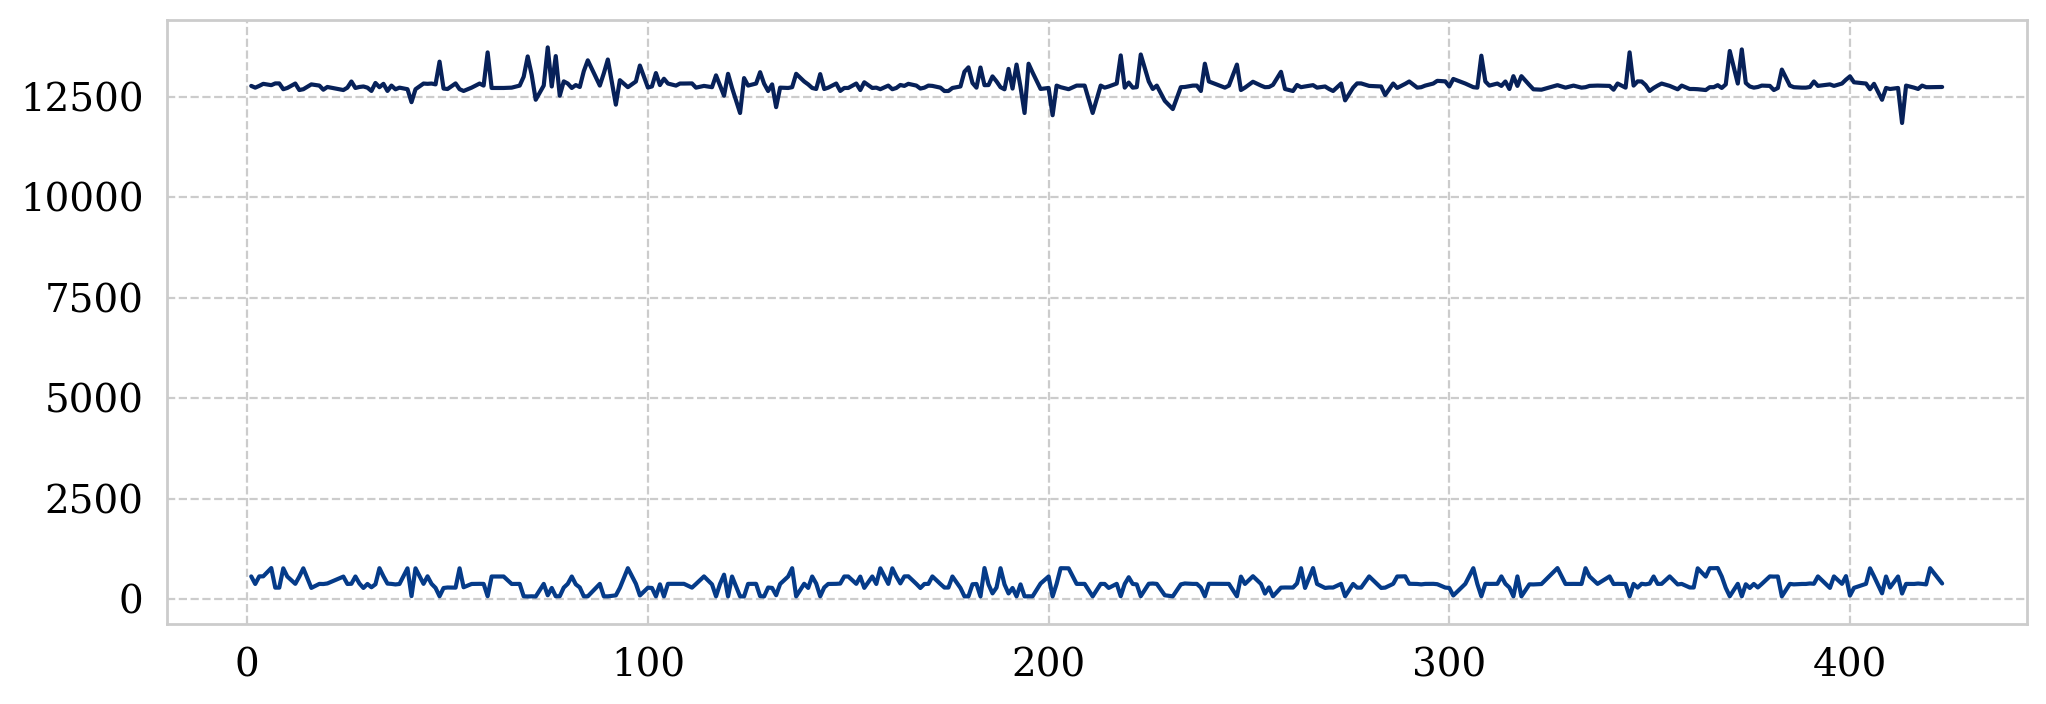

In [141]:
# Remove higher peaks than 15000 Hz.
filter_concated = filter_concated.loc[(filter_concated['Frequencies'] <= 15000)]
filter_concated['Frequencies'].plot()
filter_concated['Bandwidths'].plot()

In [206]:
print(mean_freq)
print(mean_bw)
optimal_bandpass = {'highcut':mean_freq-mean_bw/2,'lowcut':mean_freq+mean_bw/2}

12852.952953016986
372.2264290674596


In [155]:
print(f'Low: {round(int(optimal_bandpass["highcut"]))}, High: {int(round(optimal_bandpass["lowcut"]))}')

HIGHCUT: 12666, LOWCUT: 13039


In [204]:
sample_freq

24902.43874526499

In [288]:
resample_freqs=resample_freqs.rename(columns={0:'ResampleFreq'})

In [297]:
len(filtered_resampled_csvs[1])

371999

In [318]:
signal = filtered_resampled_csvs[1]
len(signal)

371999

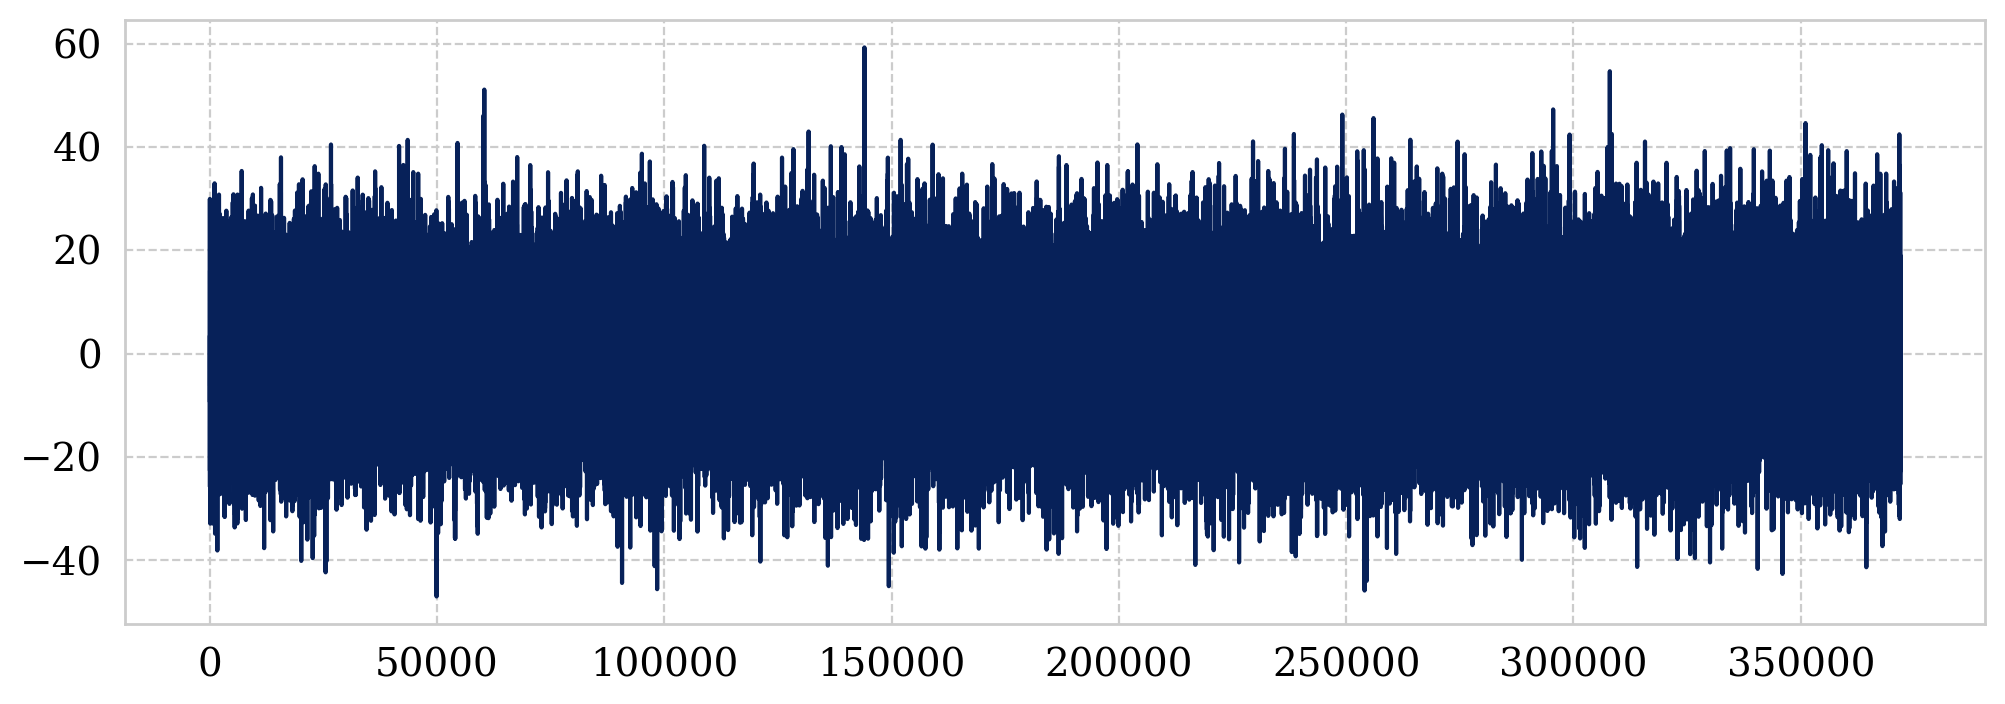

In [320]:
signal = filtered_resampled_csvs[1]
plt.plot(signal)

In [327]:
signal = np.array(signal)
signal.shape

(371999, 1)

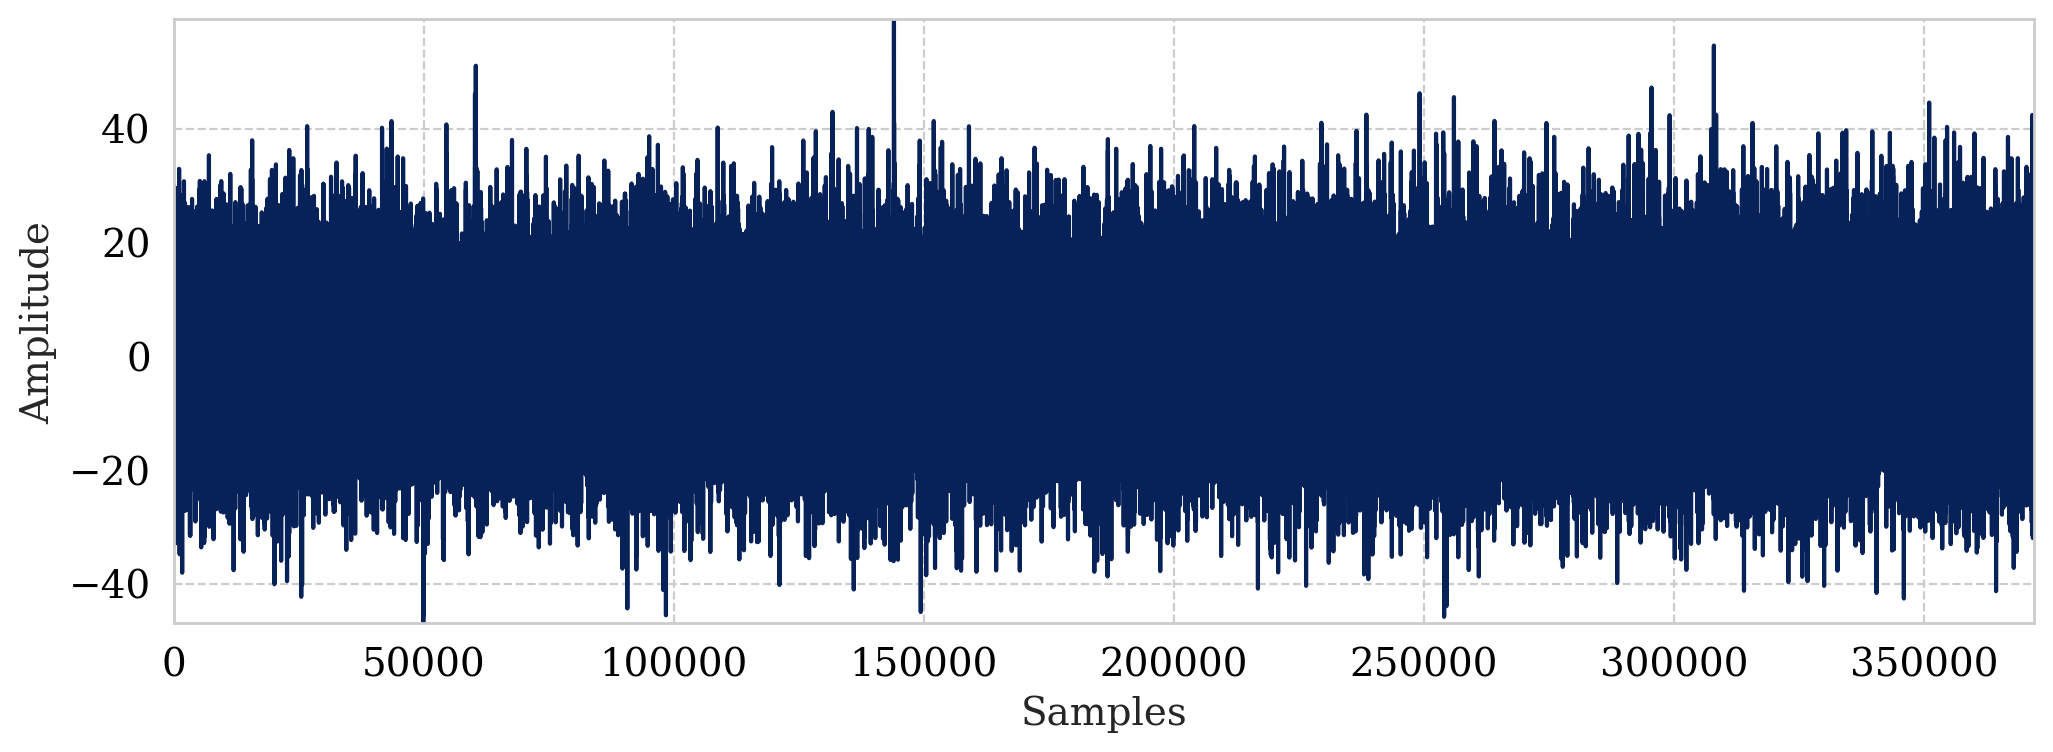

Text(0.5, 1.0, 'Interval 1 from WT04 filtered with average optimal bandpass from SK \n Component: Gearbox')

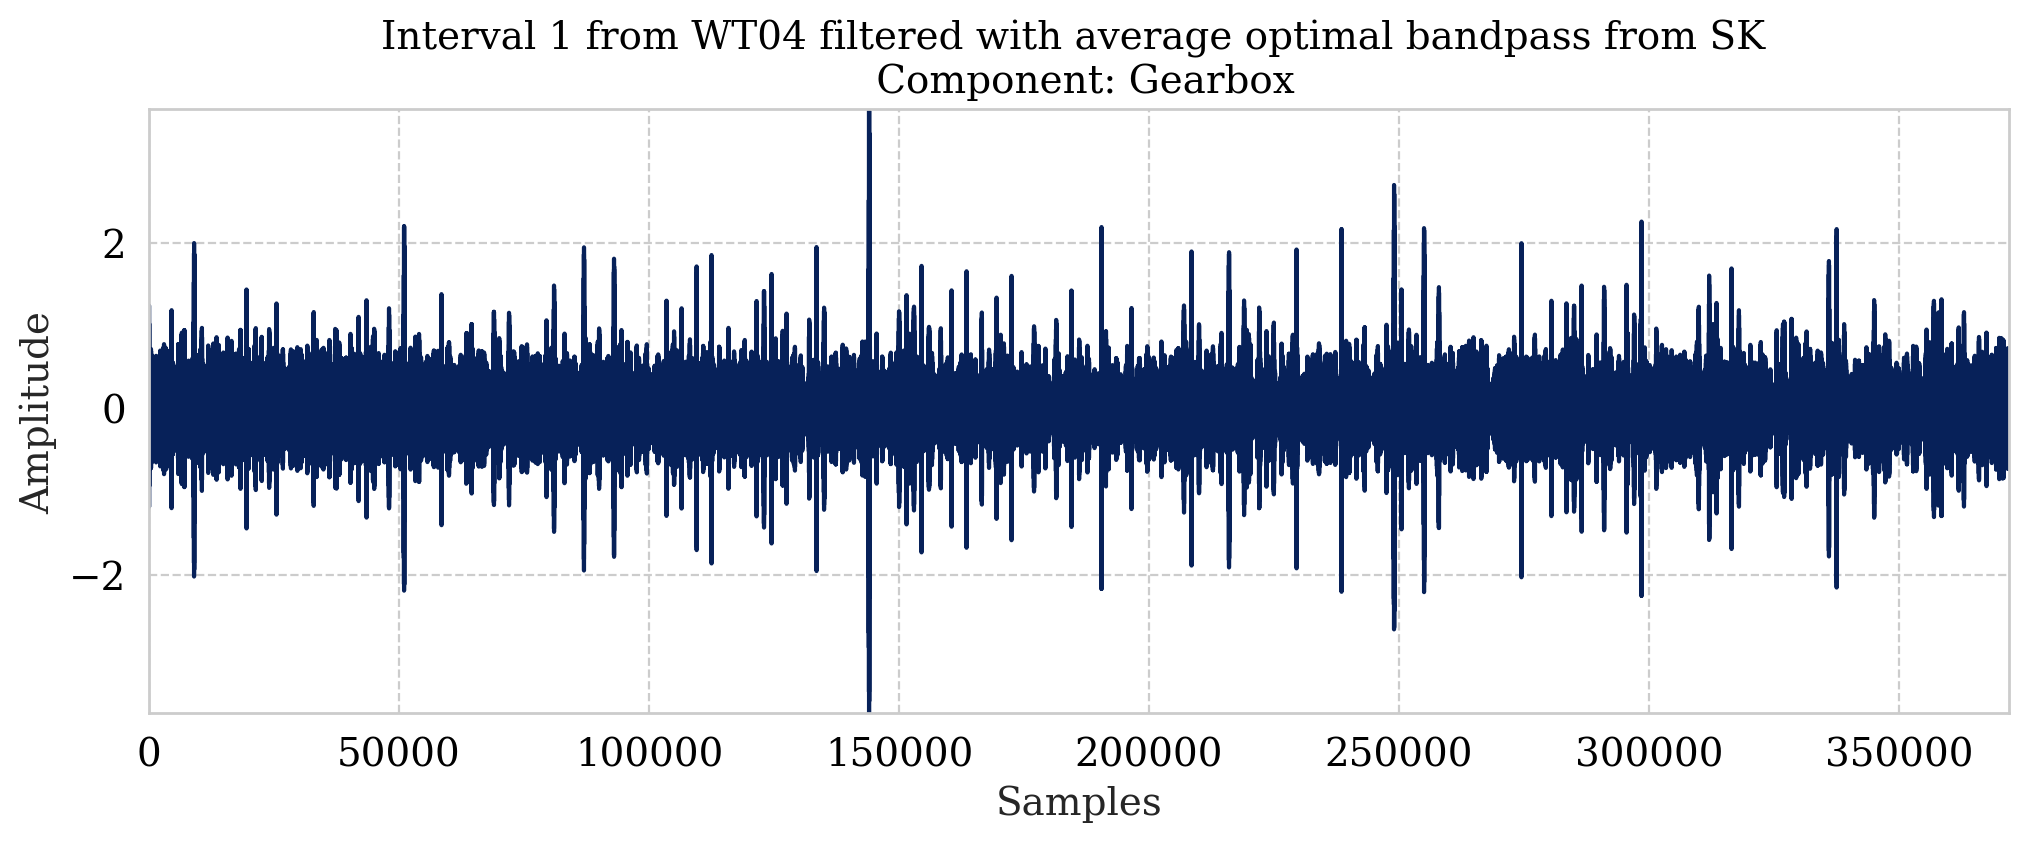

In [347]:
# Perform bandpass filtering

optimal_bandpass = []
i=1

low = round(int(optimal_bandpass["highcut"]))
high = round(int(optimal_bandpass["lowcut"]))
fs_resample = resample_freqs['ResampleFreq'].iloc[i]
signal = filtered_resampled_csvs[i]
y = filters.butter_bandpass_filter(signal,low,high,fs_resample)
optimal_bandpass.append(y)

plt.plot(signal)
plt.margins(0)
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.show()
plt.title('Resampled signal with highpass filtering')
plt.plot(y)
plt.xlabel("Samples")
plt.margins(0)
plt.ylabel("Amplitude")
plt.title(f'Interval {i} from WT04 filtered with average optimal bandpass from SK \n Component: Gearbox')


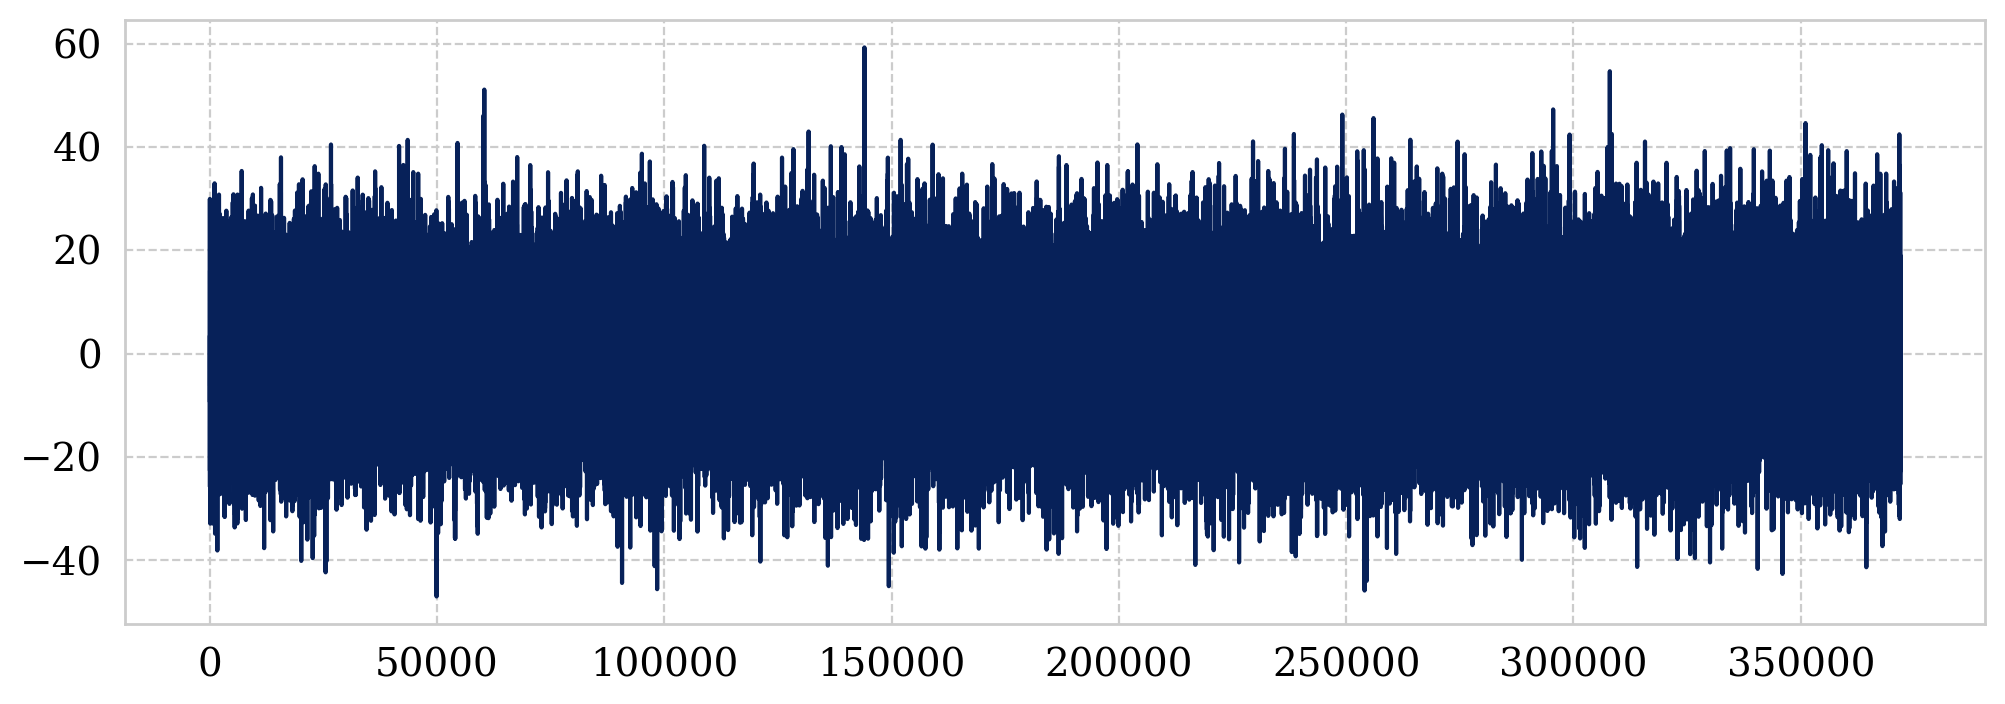

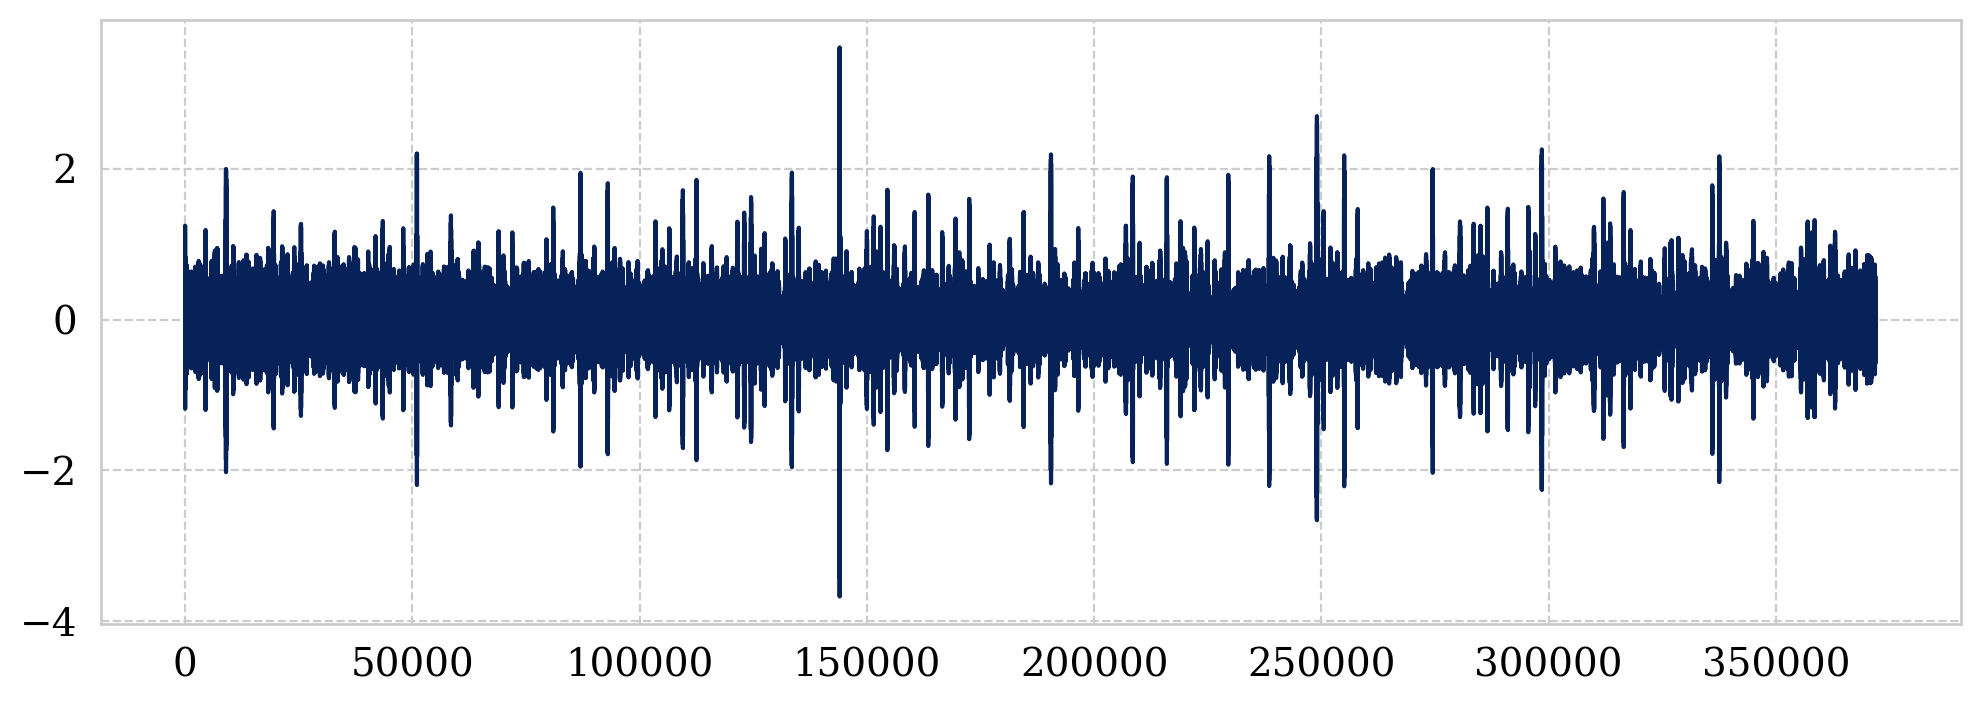

## 4. Demodulasation using EEMD signals

In [ ]:
from PyEMD import EEMD
import numpy as np
import pylab as plt
# Define signal
S = vib_signal[0][0:10000]
t = times[0][0:10000]

# Assign EEMD to `eemd` variable
eemd = EEMD()
# Say we want detect extrema using parabolic method
emd = eemd.EMD
emd.extrema_detection="parabol"
# Execute EEMD on S
eIMFs = eemd.eemd(S, t)
nIMFs = eIMFs.shape[0]
# Plot results
plt.figure(figsize=(12,9))
plt.subplot(nIMFs+1, 1, 1)
plt.plot(t, S, 'r')

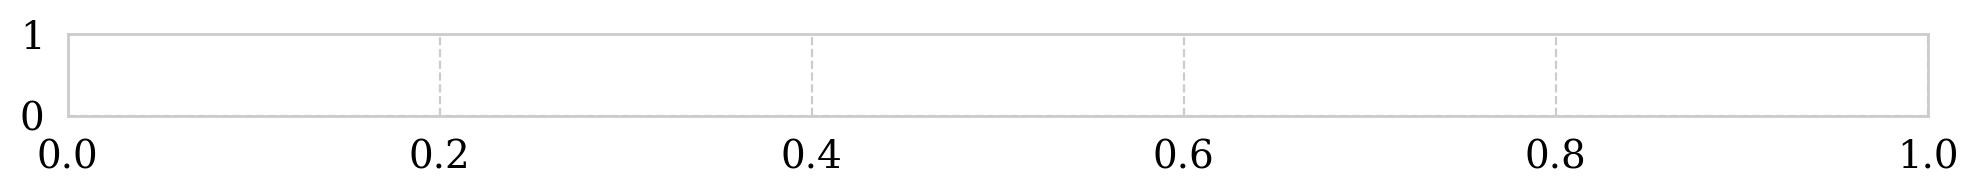

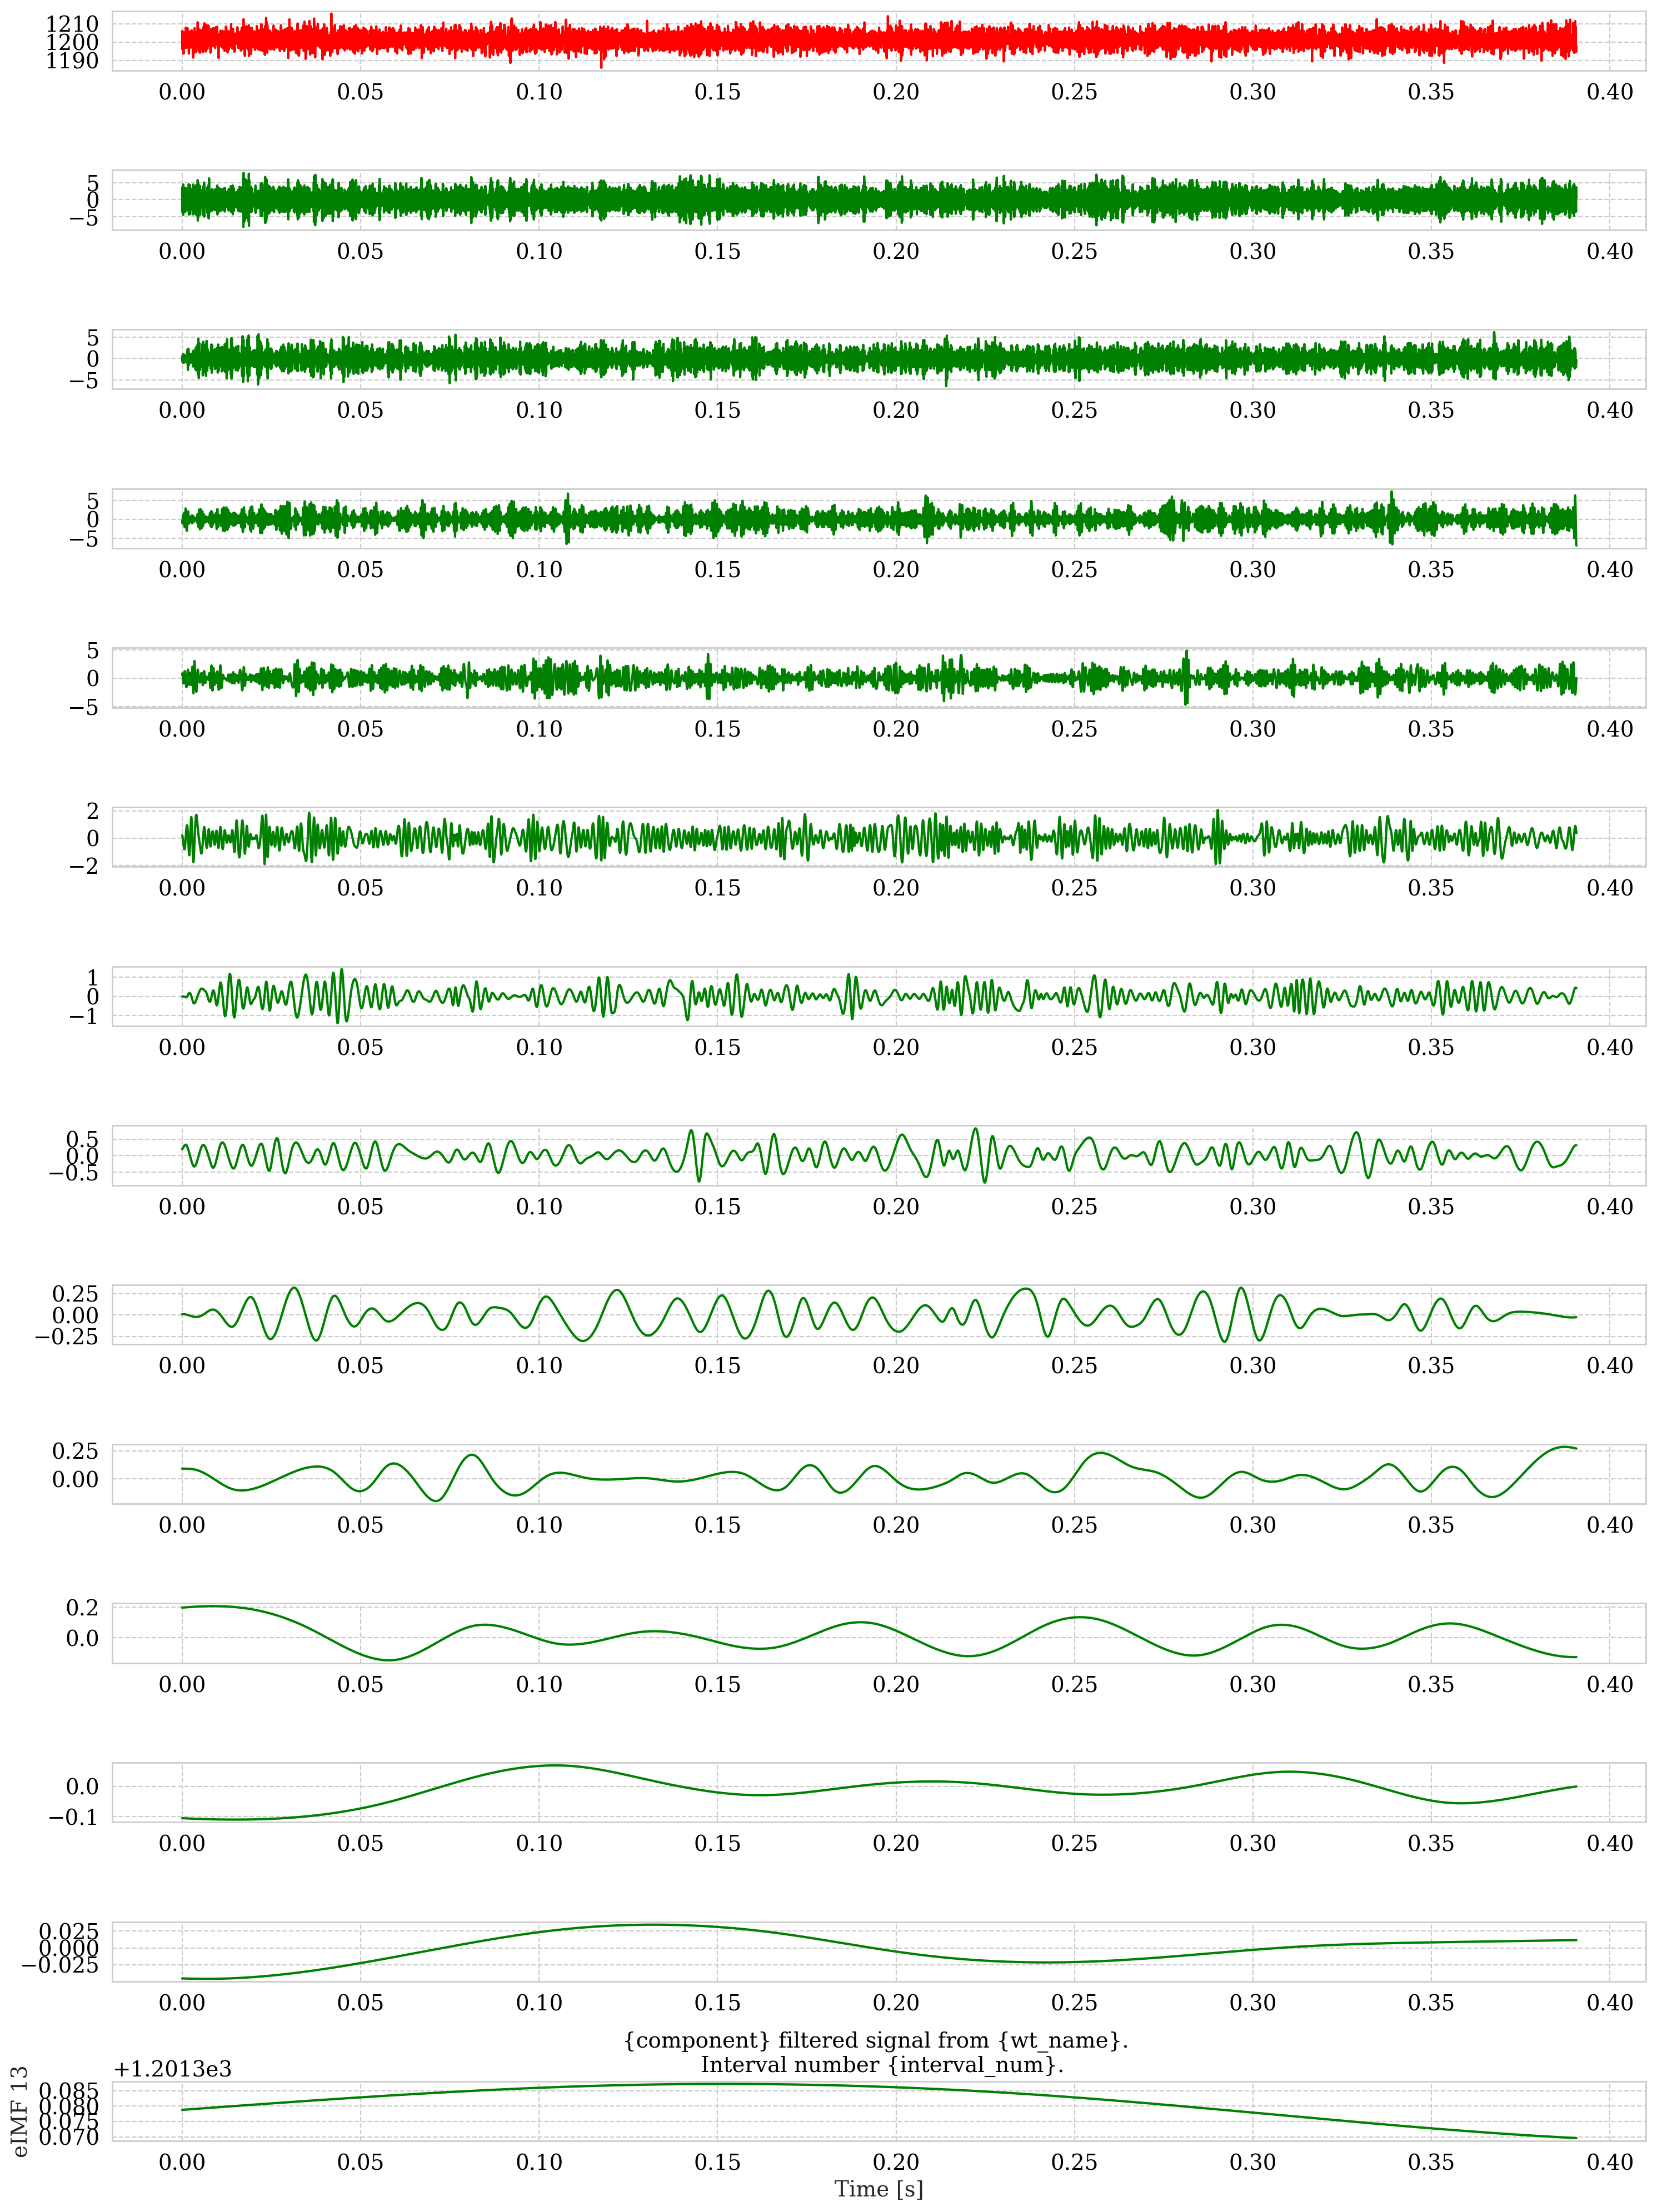

In [11]:
envelope_emd.eemd('WT01',1,'gearbox',vib_signal[0][0:10000],times[0][0:10000],True)

## 5. Selecting IMF: Correlation coefficient

## 6. Envelope spectral analysis

## 7. Frequency study (fault characteristics), fault development